# Variant effect prediction - ablation study

In [36]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

In [15]:
plot_dir = "../../results/plots/"

In [28]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency\n(no neural net)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50%\nmost conserved",
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include\nclosest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight\nconserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace\nnon-conserved",
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/64/32/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 64",
    r"multiz100way/89/32/16/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32 (VEP time)",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64 (VEP time)",
}

In [18]:
models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()
model_renaming = {}
len(models)

43

In [19]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(models):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 43/43 [00:08<00:00,  5.36it/s]


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64,msa_multiz100way/89
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-3.962891,-4.222656,-4.625000,-5.539062,-4.976562,-4.851562,-5.261719,-4.855469,-5.144531,-3.044522
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-3.466797,-3.740234,-3.605469,-3.511719,-3.679688,-3.548828,-3.564453,-3.611328,-3.443359,-2.197225
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-3.503906,-3.537109,-3.921875,-3.628906,-3.464844,-3.560547,-3.705078,-3.652344,-3.607422,-1.098612
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-3.228516,-3.494141,-3.699219,-3.068359,-3.597656,-4.164062,-2.513672,-2.882812,-3.027344,-0.916291
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,-4.339844,-4.593750,-4.132812,-3.503906,-3.048828,-3.205078,-1.589844,-1.616211,-1.604492,-3.091042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,-7.183594,-7.046875,-6.898438,-6.769531,-6.261719,-6.101562,-6.398438,-5.570312,-6.238281,-3.806662
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,-3.962891,-3.265625,-3.601562,-3.027344,-2.386719,-3.025391,-1.205078,-1.367188,-1.514648,-1.098612
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,-1.624023,-1.676758,-1.402344,-1.253906,-0.917969,-0.397461,-0.640625,-0.664062,0.082031,1.252763
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,0.125000,-0.088867,-0.010742,0.140137,0.005859,0.051758,0.153320,0.014648,0.035156,0.000000


In [20]:
V["phyloP"] = pd.read_parquet(d / "phyloP.parquet").score
V["phyloP-Zoonomia"] = pd.read_parquet(d / "phyloP-Zoonomia.parquet").score
V["phastCons"] = pd.read_parquet(d / "phastCons.parquet").score
V["CADD"] = pd.read_parquet(d / "CADD.RawScore.parquet").score
V["ESM-1b"] = pd.read_parquet(d / "ESM-1b.parquet").score
V["NT"] = pd.read_parquet(d / "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.parquet").score

In [21]:
models = [model_renaming.get(m, m) for m in models]
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/44/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True',
 'multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True',
 'multiz10

In [22]:
V.label.value_counts()

label
Rare          4869209
Common        4869209
Pathogenic      22660
Frequent          189
Name: count, dtype: int64

## ClinVar pathogenic vs. gnomAD common (missense)

In [23]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=models + ["ESM-1b", "phyloP", "CADD", "NT", "phyloP-Zoonomia", "phastCons"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

In [24]:
rows = []
for m in models:
    AUROC = roc_auc_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    AUPRC = average_precision_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_clinvar

,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794
3,multiz100way/89/128/64/True/defined.phastCons....,0.960399,0.972493
4,multiz100way/89/128/64/True/defined.phastCons....,0.959882,0.972304
5,multiz100way/89/128/64/True/defined.phastCons....,0.958839,0.971034
6,multiz100way/99/128/64/True/defined.phastCons....,0.950688,0.964791
7,multiz100way/99/128/64/True/defined.phastCons....,0.947808,0.962989
8,multiz100way/99/128/64/True/defined.phastCons....,0.951931,0.965355
9,multiz100way_mammals/51/128/64/True/defined.ph...,0.962291,0.974539


In [25]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

In [29]:
results_clinvar["Ablation"] = None
for k, v in hparam_name.items():
    results_clinvar.loc[results_clinvar.Model.str.match(k), "Ablation"] = v
results_clinvar2 = results_clinvar.dropna()
results_clinvar2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
51 mammals                        3
51 vertebrates                    3
Window size = 256                 3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
Window size = 4 (VEP time)        3
Window size = 8 (VEP time)        3
Window size = 16 (VEP time)       3
Window size = 32 (VEP time)       3
Window size = 64 (VEP time)       3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

In [30]:
results_clinvar2.shape

(43, 4)

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

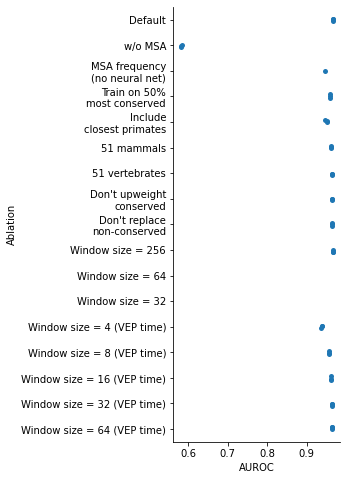

In [33]:
plt.figure(figsize=(3,8))
g = sns.stripplot(
    data=results_clinvar2,
    y="Ablation",
    x="AUROC",
    order=hparam_name.values(),
)
sns.despine()

## COSMIC frequent vs. gnomAD common (missense)

In [49]:
V_cosmic = V[
    (V.source == "COSMIC") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_cosmic.dropna(subset=models + ["ESM-1b", "phyloP", "CADD", "phyloP-Zoonomia", "phastCons"], inplace=True)
V_cosmic.label.value_counts()

label
Common      13118
Frequent      189
Name: count, dtype: int64

In [50]:
rows = []
for m in models:
    AUROC = roc_auc_score(V_cosmic.label=="Frequent", -V_cosmic[m])
    AUPRC = average_precision_score(V_cosmic.label=="Frequent", -V_cosmic[m])
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_cosmic

,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.758927,0.348005
1,multiz100way/89/128/64/True/defined.phastCons....,0.758857,0.342592
2,multiz100way/89/128/64/True/defined.phastCons....,0.759372,0.334161
3,multiz100way/89/128/64/True/defined.phastCons....,0.756612,0.243975
4,multiz100way/89/128/64/True/defined.phastCons....,0.755791,0.251858
5,multiz100way/89/128/64/True/defined.phastCons....,0.754543,0.214035
6,multiz100way/99/128/64/True/defined.phastCons....,0.737197,0.215715
7,multiz100way/99/128/64/True/defined.phastCons....,0.736728,0.215393
8,multiz100way/99/128/64/True/defined.phastCons....,0.736064,0.203023
9,multiz100way_mammals/51/128/64/True/defined.ph...,0.762567,0.314739


In [51]:
results_cosmic["Ablation"] = None
for k, v in hparam_name.items():
    results_cosmic.loc[results_cosmic.Model.str.match(k), "Ablation"] = v
results_cosmic2 = results_cosmic.dropna()
results_cosmic2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
51 mammals                        3
51 vertebrates                    3
Window size = 256                 3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
Window size = 4 (VEP time)        3
Window size = 8 (VEP time)        3
Window size = 16 (VEP time)       3
Window size = 32 (VEP time)       3
Window size = 64 (VEP time)       3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

In [53]:
results_cosmic2.groupby("Ablation").AUPRC.mean().sort_values(ascending=False)

Ablation
Window size = 256                 0.358707
Default                           0.341586
Window size = 64 (VEP time)       0.334148
51 vertebrates                    0.333644
Don't replace\nnon-conserved      0.327944
Window size = 32 (VEP time)       0.317126
51 mammals                        0.316639
Don't upweight\nconserved         0.297190
MSA frequency\n(no neural net)    0.266196
Window size = 16 (VEP time)       0.242351
Train on 50%\nmost conserved      0.236623
Include\nclosest primates         0.211377
Window size = 8 (VEP time)        0.187609
Window size = 4 (VEP time)        0.134138
w/o MSA                           0.014130
Name: AUPRC, dtype: float64

## OMIM pathogenic vs. gnomAD common (regulatory)

In [58]:
omim_variant_type_dict = {
    "5_prime_UTR_variant": "5' UTR",
    "upstream_gene_variant": "Promoter",
    "intergenic_variant": "Enhancer",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}
cs = list(omim_variant_type_dict.keys())
cs

['5_prime_UTR_variant',
 'upstream_gene_variant',
 'intergenic_variant',
 '3_prime_UTR_variant',
 'non_coding_transcript_exon_variant']

In [59]:
V_omim = V[
    (V.source == "OMIM") |
    (
        (V.label == "Common") &
        np.any([V.consequence.str.contains(c) for c in cs], axis=0) &
        ~V.consequence.str.contains("missense")
    )
].copy()
V_omim.label.value_counts()

label
Common        2321067
Pathogenic        406
Name: count, dtype: int64

In [64]:
def get_subtitle(n_pathogenic, n_common):
    return f"all\nn={n_pathogenic} vs. {n_common}"

pos_prop = []

rows = []

V_c = V_omim.copy()
V_c.dropna(subset=models + ["phyloP", "CADD", "phyloP-Zoonomia", "phastCons"], inplace=True)

n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))
    
for m in tqdm(models):
    AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
    rows.append([m, AUPRC, subtitle])
results_omim = pd.DataFrame(rows, columns=["Model", "AUPRC", "subtitle"])
results_omim

100%|██████████| 43/43 [00:39<00:00,  1.10it/s]


,Model,AUPRC,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,0.116074,all\nn=406 vs. 2284702
1,multiz100way/89/128/64/True/defined.phastCons....,0.122366,all\nn=406 vs. 2284702
2,multiz100way/89/128/64/True/defined.phastCons....,0.106964,all\nn=406 vs. 2284702
3,multiz100way/89/128/64/True/defined.phastCons....,0.136442,all\nn=406 vs. 2284702
4,multiz100way/89/128/64/True/defined.phastCons....,0.113302,all\nn=406 vs. 2284702
5,multiz100way/89/128/64/True/defined.phastCons....,0.116800,all\nn=406 vs. 2284702
6,multiz100way/99/128/64/True/defined.phastCons....,0.146717,all\nn=406 vs. 2284702
7,multiz100way/99/128/64/True/defined.phastCons....,0.111487,all\nn=406 vs. 2284702
8,multiz100way/99/128/64/True/defined.phastCons....,0.124391,all\nn=406 vs. 2284702
9,multiz100way_mammals/51/128/64/True/defined.ph...,0.064509,all\nn=406 vs. 2284702


In [65]:
results_omim["Ablation"] = None
for k, v in hparam_name.items():
    results_omim.loc[results_omim.Model.str.match(k), "Ablation"] = v
results_omim2 = results_omim.dropna()
results_omim2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
51 mammals                        3
51 vertebrates                    3
Window size = 256                 3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
Window size = 4 (VEP time)        3
Window size = 8 (VEP time)        3
Window size = 16 (VEP time)       3
Window size = 32 (VEP time)       3
Window size = 64 (VEP time)       3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

In [70]:
results_omim2.groupby("Ablation").agg({"AUPRC": ["mean", "std"]}).sort_values(("AUPRC", "mean"), ascending=False)

AUPRC          
                                    mean       std
Ablation                                          
Include\nclosest primates       0.127532  0.017824
Train on 50%\nmost conserved    0.122181  0.012474
Don't upweight\nconserved       0.122172  0.015794
Window size = 256               0.116618  0.010107
Default                         0.115135  0.007744
Window size = 64 (VEP time)     0.107221  0.009573
Window size = 32 (VEP time)     0.106828  0.013797
Don't replace\nnon-conserved    0.102198  0.002058
Window size = 16 (VEP time)     0.093760  0.009118
51 vertebrates                  0.090348  0.006859
Window size = 8 (VEP time)      0.078342  0.007938
51 mammals                      0.066804  0.002449
Window size = 4 (VEP time)      0.049417  0.002208
MSA frequency\n(no neural net)  0.029766       NaN
w/o MSA                         0.000206  0.000003

## gnomAD rare vs. common

In [37]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    return _compute_odds_ratio(df)

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [38]:
# TODO: should maybe make a lineplot with different thresholds
tq = 1e-3

rows = []
df_c = V[V.source=="gnomAD"]
df_c = df_c[df_c.AC != df_c.AN - 1]
df_c = df_c.dropna(subset=models + ["phyloP", "CADD", "phyloP-Zoonomia", "phastCons"])
for m in tqdm(models):
    subtitle = get_subtitle("All", (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
    OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c[[m, "label"]], tq, m)
    rows.append([m, OR, p_value, min_counts, cil, ciu, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results_gnomad

100%|██████████| 43/43 [04:07<00:00,  5.76s/it]


,Model,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,38.350315,0.000000e+00,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,35.517883,0.000000e+00,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,37.105859,0.000000e+00,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/128/64/True/defined.phastCons....,29.126281,0.000000e+00,320,25.995513,32.634102,All\nn=4812825 vs. 4811795
4,multiz100way/89/128/64/True/defined.phastCons....,29.507696,0.000000e+00,316,26.317691,33.084365,All\nn=4812825 vs. 4811795
5,multiz100way/89/128/64/True/defined.phastCons....,27.437477,0.000000e+00,339,24.564744,30.646163,All\nn=4812825 vs. 4811795
6,multiz100way/99/128/64/True/defined.phastCons....,33.186598,0.000000e+00,282,29.407712,37.451070,All\nn=4812825 vs. 4811795
7,multiz100way/99/128/64/True/defined.phastCons....,31.135069,0.000000e+00,300,27.688438,35.010733,All\nn=4812825 vs. 4811795
8,multiz100way/99/128/64/True/defined.phastCons....,30.300248,0.000000e+00,308,26.986043,34.021476,All\nn=4812825 vs. 4811795
9,multiz100way_mammals/51/128/64/True/defined.ph...,33.340423,0.000000e+00,281,29.537915,37.632440,All\nn=4812825 vs. 4811795


In [40]:
results_gnomad["Ablation"] = None
for k, v in hparam_name.items():
    results_gnomad.loc[results_gnomad.Model.str.match(k), "Ablation"] = v
results_gnomad2 = results_gnomad.dropna()
results_gnomad2.Ablation.value_counts()

Ablation
Default                           3
Train on 50%\nmost conserved      3
Include\nclosest primates         3
51 mammals                        3
51 vertebrates                    3
Window size = 256                 3
w/o MSA                           3
Don't upweight\nconserved         3
Don't replace\nnon-conserved      3
Window size = 4 (VEP time)        3
Window size = 8 (VEP time)        3
Window size = 16 (VEP time)       3
Window size = 32 (VEP time)       3
Window size = 64 (VEP time)       3
MSA frequency\n(no neural net)    1
Name: count, dtype: int64

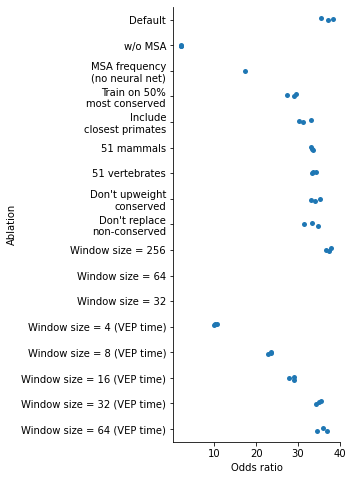

In [42]:
plt.figure(figsize=(3,8))
g = sns.stripplot(
    data=results_gnomad2,
    y="Ablation",
    x="Odds ratio",
    order=hparam_name.values(),
)
sns.despine()

## Merged

In [43]:
merged_res = results_clinvar2.merge(results_gnomad2, how="inner", on=["Model", "Ablation"])
merged_res

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Default,38.350315,0.000000e+00,245,33.694110,43.649963,All\nn=4812825 vs. 4811795
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Default,35.517883,0.000000e+00,264,31.350007,40.239863,All\nn=4812825 vs. 4811795
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Default,37.105859,0.000000e+00,253,32.666287,42.148800,All\nn=4812825 vs. 4811795
3,multiz100way/89/128/64/True/defined.phastCons....,0.960399,0.972493,Train on 50%\nmost conserved,29.126281,0.000000e+00,320,25.995513,32.634102,All\nn=4812825 vs. 4811795
4,multiz100way/89/128/64/True/defined.phastCons....,0.959882,0.972304,Train on 50%\nmost conserved,29.507696,0.000000e+00,316,26.317691,33.084365,All\nn=4812825 vs. 4811795
5,multiz100way/89/128/64/True/defined.phastCons....,0.958839,0.971034,Train on 50%\nmost conserved,27.437477,0.000000e+00,339,24.564744,30.646163,All\nn=4812825 vs. 4811795
6,multiz100way/99/128/64/True/defined.phastCons....,0.950688,0.964791,Include\nclosest primates,33.186598,0.000000e+00,282,29.407712,37.451070,All\nn=4812825 vs. 4811795
7,multiz100way/99/128/64/True/defined.phastCons....,0.947808,0.962989,Include\nclosest primates,31.135069,0.000000e+00,300,27.688438,35.010733,All\nn=4812825 vs. 4811795
8,multiz100way/99/128/64/True/defined.phastCons....,0.951931,0.965355,Include\nclosest primates,30.300248,0.000000e+00,308,26.986043,34.021476,All\nn=4812825 vs. 4811795
9,multiz100way_mammals/51/128/64/True/defined.ph...,0.962291,0.974539,51 mammals,33.340423,0.000000e+00,281,29.537915,37.632440,All\nn=4812825 vs. 4811795


In [45]:
merged_res.groupby("Ablation").AUROC.mean().sort_values(ascending=False)

Ablation
Window size = 256                 0.966312
Default                           0.966088
Window size = 64 (VEP time)       0.965343
Window size = 32 (VEP time)       0.964346
Don't upweight\nconserved         0.964285
51 vertebrates                    0.964019
Don't replace\nnon-conserved      0.963900
51 mammals                        0.961653
Window size = 16 (VEP time)       0.961529
Train on 50%\nmost conserved      0.959707
Window size = 8 (VEP time)        0.957605
Include\nclosest primates         0.950142
MSA frequency\n(no neural net)    0.946779
Window size = 4 (VEP time)        0.937756
w/o MSA                           0.581954
Name: AUROC, dtype: float64

In [47]:
merged_res.groupby("Ablation")["Odds ratio"].mean().sort_values(ascending=False)

Ablation
Window size = 256                 37.287420
Default                           36.991352
Window size = 64 (VEP time)       35.799589
Window size = 32 (VEP time)       34.945424
Don't upweight\nconserved         34.162271
51 vertebrates                    33.836697
51 mammals                        33.343207
Don't replace\nnon-conserved      33.121769
Include\nclosest primates         31.540638
Train on 50%\nmost conserved      28.690485
Window size = 16 (VEP time)       28.580792
Window size = 8 (VEP time)        23.324720
MSA frequency\n(no neural net)    17.344245
Window size = 4 (VEP time)        10.181923
w/o MSA                            1.933077
Name: Odds ratio, dtype: float64

In [23]:
markers = {}
for hparam in hparam_name.values():
    markers[hparam] = 'X' if hparam == "MSA frequency\n(no neural net)" else 'o'

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

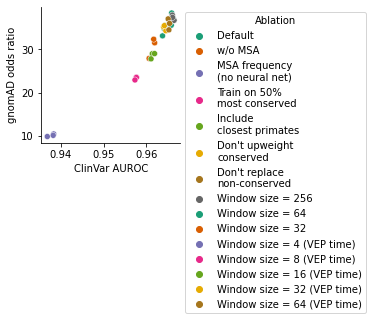

In [24]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

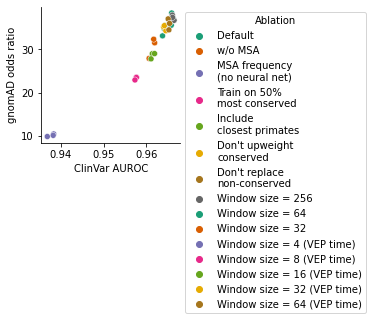

In [25]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("ClinVar AUROC")
plt.ylabel("gnomAD odds ratio")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Text(0, 0.5, 'gnomAD odds ratio')

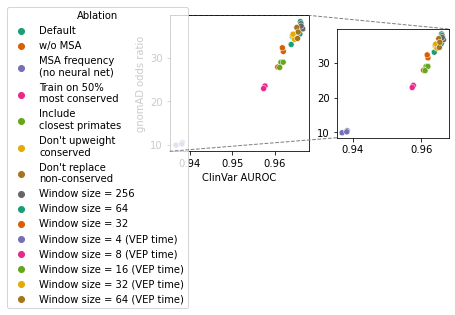

In [26]:
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    style="Ablation", markers=markers,
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.1))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res[merged_res.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
    style="Ablation", markers=markers,
)

# doesn't look good
#x1, x2 = axins.get_xlim()
#y1, y2 = axins.get_ylim()
#axins.set_xlim(x1-1e-2, x2+1e-2)
#axins.set_ylim(y1, y2)

axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.pdf", bbox_inches="tight")

In [27]:
axins.get_ylim()

(8.472979036983716, 39.77304522643074)

In [28]:
#merged_res_avg = merged_res.groupby("Ablation").agg({"AUROC": "mean", "Odds ratio": "mean"}).reset_index()
#merged_res_avg

In [29]:
"""
plt.figure(figsize=(2.5,2.5))
g = sns.scatterplot(
    data=merged_res_avg,
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(-1.2, 1.05))


#axins = inset_axes(g, width='60%', height='60%', loc='center')

axins = inset_axes(g, 
                   width='100%',  # Width of the inset plot (as a percentage of the main plot)
                   height='100%',  # Height of the inset plot
                   loc='center', 
                   bbox_to_anchor=(1.2, 0.1, 0.8, 0.8),  # (x, y, width, height) relative to the size and position of the main plot
                   bbox_transform=g.transAxes,  # Coordinate system transformation
                   borderpad=0)  # Optional padding around the inset plot


sns.scatterplot(
    data=merged_res_avg[merged_res_avg.Ablation != "w/o MSA"],
    x="AUROC",
    y="Odds ratio",
    hue="Ablation",
    hue_order=hparam_name.values(),
    palette="Dark2",
    legend=False,
    ax=axins,
)
axins.set_xlabel("")
axins.set_ylabel("")
mark_inset(g, axins, loc1=3, loc2=1, fc="none", ec="0.5", linestyle="--")
g.set_xlabel("ClinVar AUROC")
g.set_ylabel("gnomAD odds ratio")
#plt.savefig(plot_dir + "ablation.svg", bbox_inches="tight")
""";

## Reducing window size

In [35]:
df = merged_res.copy()
df.Ablation.replace("Default", "Window size = 128 (VEP time)", inplace=True)
df = df[df.Ablation.str.contains("VEP time")]
df["Window size"] = df.Ablation.str.split().str[3].astype(int)
df

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle,Window size
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Window size = 128 (VEP time),38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795,128
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Window size = 128 (VEP time),35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795,128
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Window size = 128 (VEP time),37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795,128
12,multiz100way/89/128/64/True/defined.phastCons....,0.938297,0.953079,Window size = 4 (VEP time),10.490310,0.0,844,9.760918,11.274206,All\nn=4812825 vs. 4811795,4
13,multiz100way/89/128/64/True/defined.phastCons....,0.936796,0.950958,Window size = 4 (VEP time),9.895709,0.0,887,9.222259,10.618338,All\nn=4812825 vs. 4811795,4
14,multiz100way/89/128/64/True/defined.phastCons....,0.938173,0.951886,Window size = 4 (VEP time),10.159750,0.0,868,9.461876,10.909096,All\nn=4812825 vs. 4811795,4
15,multiz100way/89/128/64/True/defined.phastCons....,0.957736,0.969280,Window size = 8 (VEP time),23.553613,0.0,394,21.250756,26.106021,All\nn=4812825 vs. 4811795,8
16,multiz100way/89/128/64/True/defined.phastCons....,0.957702,0.968806,Window size = 8 (VEP time),23.497577,0.0,394,21.200093,26.044042,All\nn=4812825 vs. 4811795,8
17,multiz100way/89/128/64/True/defined.phastCons....,0.957378,0.968270,Window size = 8 (VEP time),22.922970,0.0,403,20.704496,25.379153,All\nn=4812825 vs. 4811795,8
18,multiz100way/89/128/64/True/defined.phastCons....,0.961446,0.973049,Window size = 16 (VEP time),28.964061,0.0,322,25.859601,32.441212,All\nn=4812825 vs. 4811795,16


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


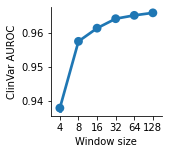

In [41]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="AUROC", errorbar="sd")
plt.ylabel("ClinVar AUROC")
sns.despine();

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


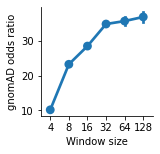

In [42]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="Odds ratio", errorbar="sd")
plt.ylabel("gnomAD odds ratio")
sns.despine();

## Increasing window size

In [44]:
df = merged_res.copy()
df.Ablation.replace("Default", "Window size = 128", inplace=True)
df = df[df.Ablation.str.contains("Window size") & ~df.Ablation.str.contains("VEP time")]
df["Window size"] = df.Ablation.str.split().str[3].astype(int)
df = df[df["Window size"].isin([128, 256])]
df

,Model,AUROC,AUPRC,Ablation,Odds ratio,p_value,min_counts,cil,ciu,subtitle,Window size
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555,Window size = 128,38.350315,0.0,245,33.694110,43.649963,All\nn=4812825 vs. 4811795,128
1,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538,Window size = 128,35.517883,0.0,264,31.350007,40.239863,All\nn=4812825 vs. 4811795,128
2,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794,Window size = 128,37.105859,0.0,253,32.666287,42.148800,All\nn=4812825 vs. 4811795,128
9,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901,Window size = 256,36.659241,0.0,256,32.296624,41.611158,All\nn=4812825 vs. 4811795,256
10,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.977664,Window size = 256,37.874235,0.0,248,33.301286,43.075145,All\nn=4812825 vs. 4811795,256
11,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.977623,Window size = 256,37.328784,0.0,252,32.854570,42.412308,All\nn=4812825 vs. 4811795,256


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


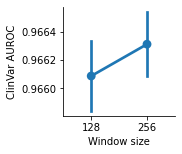

In [45]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="AUROC", errorbar="sd")
plt.ylabel("ClinVar AUROC")
sns.despine();

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


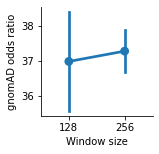

In [46]:
plt.figure(figsize=(2,2))
sns.pointplot(data=df, x="Window size", y="Odds ratio", errorbar="sd")
plt.ylabel("gnomAD odds ratio")
sns.despine();